In [1]:
import os
import pandas as pd

import xgboost as xgb
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score, recall_score, classification_report, confusion_matrix

from imblearn.over_sampling import SMOTE  # for minority over-sampling
from imblearn.pipeline import make_pipeline

from yellowbrick.classifier import ClassificationReport, ROCAUC, PrecisionRecallCurve, ConfusionMatrix
import matplotlib.pyplot as plt

In [2]:
%config Completer.use_jedi = False  # for auto-completion

## Get train and validation datasets

In [3]:
TRAINING_FILE_PATH = "gs://card_fraud_asl_project/card_fraud_train_encoded_dataset.parquet"  # <-- change this
VALIDATION_FILE_PATH = "gs://card_fraud_asl_project/card_fraud_val_encoded_dataset.parquet"  # <-- change this

df_train = pd.read_parquet(TRAINING_FILE_PATH)
df_validation = pd.read_parquet(VALIDATION_FILE_PATH)

df_train.shape, df_validation.shape

((115386, 143), (28847, 143))

Data preprocessing?

In [4]:
df_train.columns

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'card1',
       'card2', 'card3', 'C1', 'C2', 'C11',
       ...
       'R_emaildomain_web.de', 'R_emaildomain_windstream.net',
       'R_emaildomain_yahoo.co.jp', 'R_emaildomain_yahoo.co.uk',
       'R_emaildomain_yahoo.com', 'R_emaildomain_yahoo.com.mx',
       'R_emaildomain_yahoo.de', 'R_emaildomain_yahoo.es',
       'R_emaildomain_yahoo.fr', 'R_emaildomain_ymail.com'],
      dtype='object', length=143)

Separation of numerical and categorical columns?

In [5]:
# numeric_feature_columns = ['TransactionID', 'isFraud', 
#                            'TransactionDT', 'TransactionAmt',
#                            'card1', 'card2', 'card3',  
#                            'C1', 'C2', 'C11', 'C12', 'C13', 'C14', 'D8', 'V45',
#                            'V87', 'V258']

# categorical_feature_columns = ['ProductCD', 'card6',
#                                'P_emaildomain', 'R_emaildomain',]

## X:y split

In [6]:
y_train = df_train.isFraud # target/label column
X_train = df_train.drop('isFraud', 
                        axis=1, # columns
                        inplace=False) # The original dataframe df remains the same

y_validation = df_validation.isFraud # target/label column
X_validation = df_validation.drop('isFraud', 
                                  axis=1, # columns
                                  inplace=False) # The original dataframe df remains the same

Sanity-check: whether columns match?

In [7]:
X_train.shape, X_validation.shape

((115386, 142), (28847, 142))

In [8]:
y_train.shape, y_validation.shape

((115386,), (28847,))

Replace missing values (Null), with 0

In [9]:
X_train = X_train.fillna(0)
y_train = y_train.fillna(0)

X_validation = X_validation.fillna(0)
y_validation = y_validation.fillna(0)

Scaling

In [10]:
scaler = preprocessing.MinMaxScaler() # for numerical data

# fit as well as transform the training data
scaler.fit(X_train) 
X_train = scaler.transform(X_train)

X_validation = scaler.transform(X_validation) # ONLY transform - NOT fit - on the validation (test) data

## Model selection and training

In [11]:
smote = SMOTE(random_state=0)

xgb_class = xgb.XGBClassifier(random_state=42,
                              max_depth=12,
                              learning_rate=0.08,
                              objective="binary:logistic",
                              n_jobs=2,
                              # Though the actual majority:minority class ratio is about 11:1, we as also using SMOTE, remember?
                              scale_pos_weight=4,  
                              verbose=True)

model = make_pipeline(smote, xgb_class)

model.fit(X_train, y_train)


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:32:10] WARNING: ../src/learner.cc:541: 
Parameters: { verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:32:12] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('smote', SMOTE(random_state=0)),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.08,
                               max_delta_step=0, max_depth=12,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=2, num_parallel_tree=1, random_state=42,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=10,
                               subsample=1, tree_method='exact',
                               validate_parameters=1, verbose=True,
                               verbosity=None))])

## Model perfromance metrics

Checking similar distribution of labels

In [14]:
y_train.value_counts(normalize=True) * 100

0    92.092628
1     7.907372
Name: isFraud, dtype: float64

In [15]:
y_validation.value_counts(normalize=True) * 100

0    92.394356
1     7.605644
Name: isFraud, dtype: float64

Chosen performance metrics for trained model

In [16]:
y_pred = model.predict(X_validation)

In [17]:
predictions = model.predict_proba(X_validation)[:, 1]

# evaluate predictions
print ('ROC AUC Score: ', roc_auc_score(y_validation,
                                        predictions))

ROC AUC Score:  0.9365688959575375


In [19]:
print(confusion_matrix(y_validation,
                       y_pred))

[[25172  1481]
 [  559  1635]]


/opt/conda/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


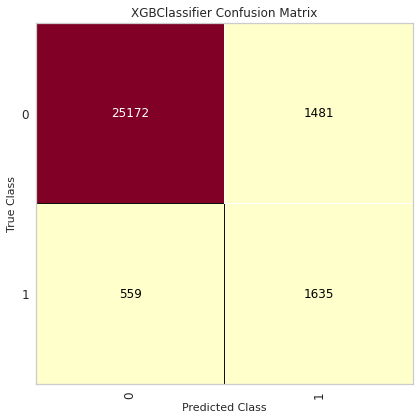

In [20]:
mapping = {0: "Genuine", 1: "Fraud"}

fig, ax = plt.subplots(figsize=(6, 6))
cm_viz = ConfusionMatrix(model,
                         classes=["0", "1"],
                         label_encoder=mapping)

cm_viz.score(X_validation, y_validation)
cm_viz.poof()

**Note**: separately calculating performance metrics for both classes..

In [21]:
print(classification_report(y_validation,
                            y_pred))

              precision    recall  f1-score   support

           0       0.98      0.94      0.96     26653
           1       0.52      0.75      0.62      2194

    accuracy                           0.93     28847
   macro avg       0.75      0.84      0.79     28847
weighted avg       0.94      0.93      0.93     28847



/opt/conda/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


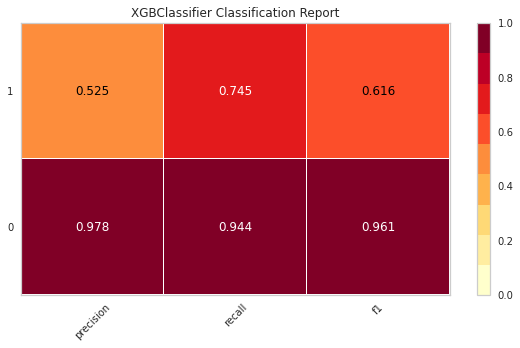

In [22]:
fig, ax = plt.subplots(figsize=(8, 5))
cm_viz = ClassificationReport(model,
                              classes=["0", "1"])

cm_viz.score(X_validation, y_validation)
cm_viz.poof()

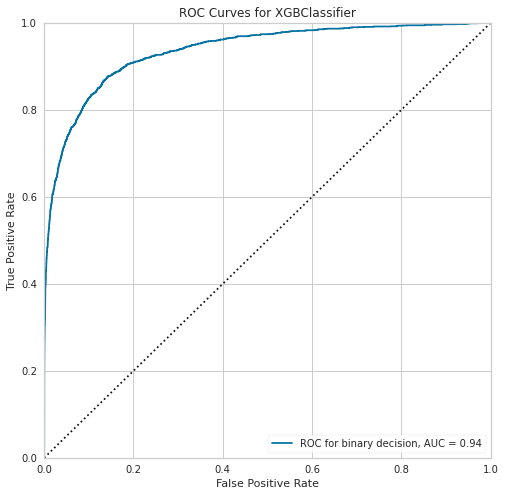

In [23]:
fig, ax = plt.subplots(figsize=(8, 8))
roc_viz = ROCAUC(model,
                 classes=["0", "1"],
                 binary=True)

roc_viz.fit(X_train, y_train)  # Fit the training data to the visualizer
roc_viz.score(X_validation, y_validation)  # Evaluate the model on the test data
roc_viz.show()

Can we visualize the decision tree?

In [24]:
fig, ax = plt.subplots(figsize=(15,10))
xgb.plot_tree(xgb_class,
              ax=ax,
              num_trees=0)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.260558 to fit
